In [2]:
  from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from skimage.util import view_as_windows
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

Xtest_a = np.load('/content/drive/MyDrive/Colab Notebooks/input/Xtest2_a.npy')
Xtest_b = np.load('/content/drive/MyDrive/Colab Notebooks/input/Xtest2_b.npy')
Xtrain_a = np.load('/content/drive/MyDrive/Colab Notebooks/input/Xtrain2_a.npy')
Xtrain_b = np.load('/content/drive/MyDrive/Colab Notebooks/input/Xtrain2_b.npy')
Ytrain_a = np.load('/content/drive/MyDrive/Colab Notebooks/input/Ytrain2_a.npy')
Ytrain_b = np.load('/content/drive/MyDrive/Colab Notebooks/input/Ytrain2_b.npy')

# Normalize y data
Ytrain_a = Ytrain_a / 255
Ytrain_b = Ytrain_b / 255

# Supervised Learning with (a)-data: pixel classification


In [ ]:
print(Xtrain_a.shape)
print(Ytrain_a.shape)
print(Xtest_a.shape)

# Assuming X is the image and Y is the corresponding segmentation mask (ground truth).

X_train, Y_train = Xtrain_a, Ytrain_a
X_train_train, X_train_test, Y_train_train, Y_train_test = \
          train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

(964908, 49)
(964908,)
(345744, 49)


## Random Forest with weighted class

In [ ]:
# Handle class imbalance by computing class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_train), y=Y_train_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

### Random Forest Classifier ###
clf_rf = RandomForestClassifier(class_weight='balanced', n_estimators=20, random_state=42)
clf_rf.fit(X_train_train, Y_train_train)

# Make predictions with Random Forest
y_pred_rf = clf_rf.predict(X_train_test)

# Evaluate Random Forest using Balanced Accuracy
balanced_acc_rf = balanced_accuracy_score(Y_train_test, y_pred_rf)
print(f"Balanced Accuracy (Random Forest): {balanced_acc_rf:.4f}")

Balanced Accuracy (Random Forest): 0.6579


In [ ]:
# Predefined hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,          # A moderate number of trees
    max_depth=10,              # Limits depth to prevent overfitting
    min_samples_split=5,       # Requires at least 5 samples to split a node
    min_samples_leaf=2,        # Requires at least 2 samples at the leaf node
    class_weight='balanced',   # To handle class imbalance
    random_state=42            # For reproducibility
)

# Train the model with the fixed parameters
rf_model.fit(X_train_train, Y_train_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_train_test)
balanced_acc_rf = balanced_accuracy_score(Y_train_test, y_pred_rf)
print(f"Balanced Accuracy (Tuned Random Forest): {balanced_acc_rf:.4f}")


Balanced Accuracy (Tuned Random Forest): 0.6797


In [ ]:
# Predefined hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=100,          # A moderate number of trees
    max_depth=20,              # Limits depth to prevent overfitting
    min_samples_split=5,       # Requires at least 5 samples to split a node
    min_samples_leaf=2,        # Requires at least 2 samples at the leaf node
    class_weight='balanced',   # To handle class imbalance
    random_state=42            # For reproducibility
)

# Train the model with the fixed parameters
rf_model.fit(X_train_train, Y_train_train)

# Make predictions and evaluate
y_pred_rf = rf_model.predict(X_train_test)
balanced_acc_rf = balanced_accuracy_score(Y_train_test, y_pred_rf)
print(f"Balanced Accuracy (Tuned Random Forest): {balanced_acc_rf:.4f}")

Balanced Accuracy (Tuned Random Forest): 0.6899


# Structured prediction task with (b)-data: image mask creation


## CNN (U-Net type) with weighted class

In [ ]:
print(Xtrain_b.shape)
print(Ytrain_b.shape)
print(Xtest_b.shape)

(547, 2304)
(547, 2304)
(196, 2304)


In [4]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Custom weighted binary cross-entropy loss function
def weighted_binary_crossentropy(y_true, y_pred, class_weights):
    # Define epsilon to avoid log(0)
    epsilon = K.epsilon()

    # Clip predictions to avoid log(0)
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # Compute the binary cross-entropy loss
    loss = -(
        class_weights[1] * y_true * K.log(y_pred) +
        class_weights[0] * (1 - y_true) * K.log(1 - y_pred)
    )

    return K.mean(loss)

# Normalize images and ensure labels are binary (0 or 1)
def preprocess_data(images, masks):
    images = np.array(images, dtype=np.float32) / 255.0  # Normalize image pixels to [0, 1]
    images = images.reshape(-1, 48, 48, 1)
    masks = np.array(masks, dtype=np.float32)
    masks = np.where(masks == 255, 1, masks)  # Convert 255 to 1 in the masks
    masks = masks.reshape(-1, 48, 48, 1)
    return images, masks

# U-Net-like architecture
def build_unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder: Downsampling path
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D((2, 2))(conv1)

    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D((2, 2))(conv2)

    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)

    # Decoder: Upsampling path
    up1 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(conv3)
    concat1 = layers.concatenate([up1, conv2], axis=-1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(concat1)
    conv4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)

    up2 = layers.Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(conv4)
    concat2 = layers.concatenate([up2, conv1], axis=-1)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(concat2)
    conv5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(conv5)

    model = models.Model(inputs, outputs)
    return model

# Load and preprocess data
X_images = Xtrain_b
Y_masks = Ytrain_b

# Preprocess images and masks, normalizing values
X, Y = preprocess_data(X_images, Y_masks)

# Reshape for Keras: Adding channel dimension to X (grayscale, so 1 channel)
X = np.expand_dims(X, axis=-1)
Y = np.expand_dims(Y, axis=-1)


In [5]:
# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

# Build the model
input_shape = (48, 48, 1)  # 48x48 images with 1 channel
model = build_unet_model(input_shape)

# Flatten Y_train to a 1D array for class weight computation
Y_train_flat = Y_train.flatten()

# Compute class weights based on the flattened array
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_flat), y=Y_train_flat)

# Create a dictionary to map each class to its corresponding weight
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Can also use 'val_accuracy'
                               patience=7,         # Number of epochs with no improvement after which training stops
                               mode='min',          # 'min' because we want to minimize the validation loss
                               restore_best_weights=True)  # Restore model weights from the epoch with the best loss

# Compile the model with the custom weighted loss
model.compile(optimizer='adam',
              loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, class_weights_dict),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train,
                    Y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping])

# Predict on validation set
Y_pred = model.predict(X_test)

# Convert predictions to binary (threshold 0.5)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Flatten predictions and ground truth for comparison
Y_test_flat = Y_test.flatten()
Y_pred_flat = Y_pred_binary.flatten()

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(Y_test_flat, Y_pred_flat)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Epoch 1/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 707ms/step - accuracy: 0.5627 - loss: 0.6867 - val_accuracy: 0.3493 - val_loss: 0.6877
Epoch 2/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 19s 673ms/step - accuracy: 0.4092 - loss: 0.6859 - val_accuracy: 0.6641 - val_loss: 0.6554
Epoch 3/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 734ms/step - accuracy: 0.6410 - loss: 0.6445 - val_accuracy: 0.5760 - val_loss: 0.6473
Epoch 4/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 635ms/step - accuracy: 0.6635 - loss: 0.6309 - val_accuracy: 0.6969 - val_loss: 0.5990
Epoch 5/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 21s 654ms/step - accuracy: 0.7436 - loss: 0.5719 - val_accuracy: 0.6604 - val_loss: 0.5702
Epoch 6/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 646ms/step - accuracy: 0.7246 - loss: 0.5479 - val_accuracy: 0.7283 - val_loss: 0.5267
Epoch 7/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 18s 628ms/step - accuracy: 0.7743 - loss: 0.5046 - val_accuracy: 0.7793 - val_loss: 0.4911
Epoch 8/50
28/28 ━━━━━━━━━━━━━━━━━━━━ 20s 622ms/step - accuracy: 0.7923 - loss: 0.4735 - val_accu

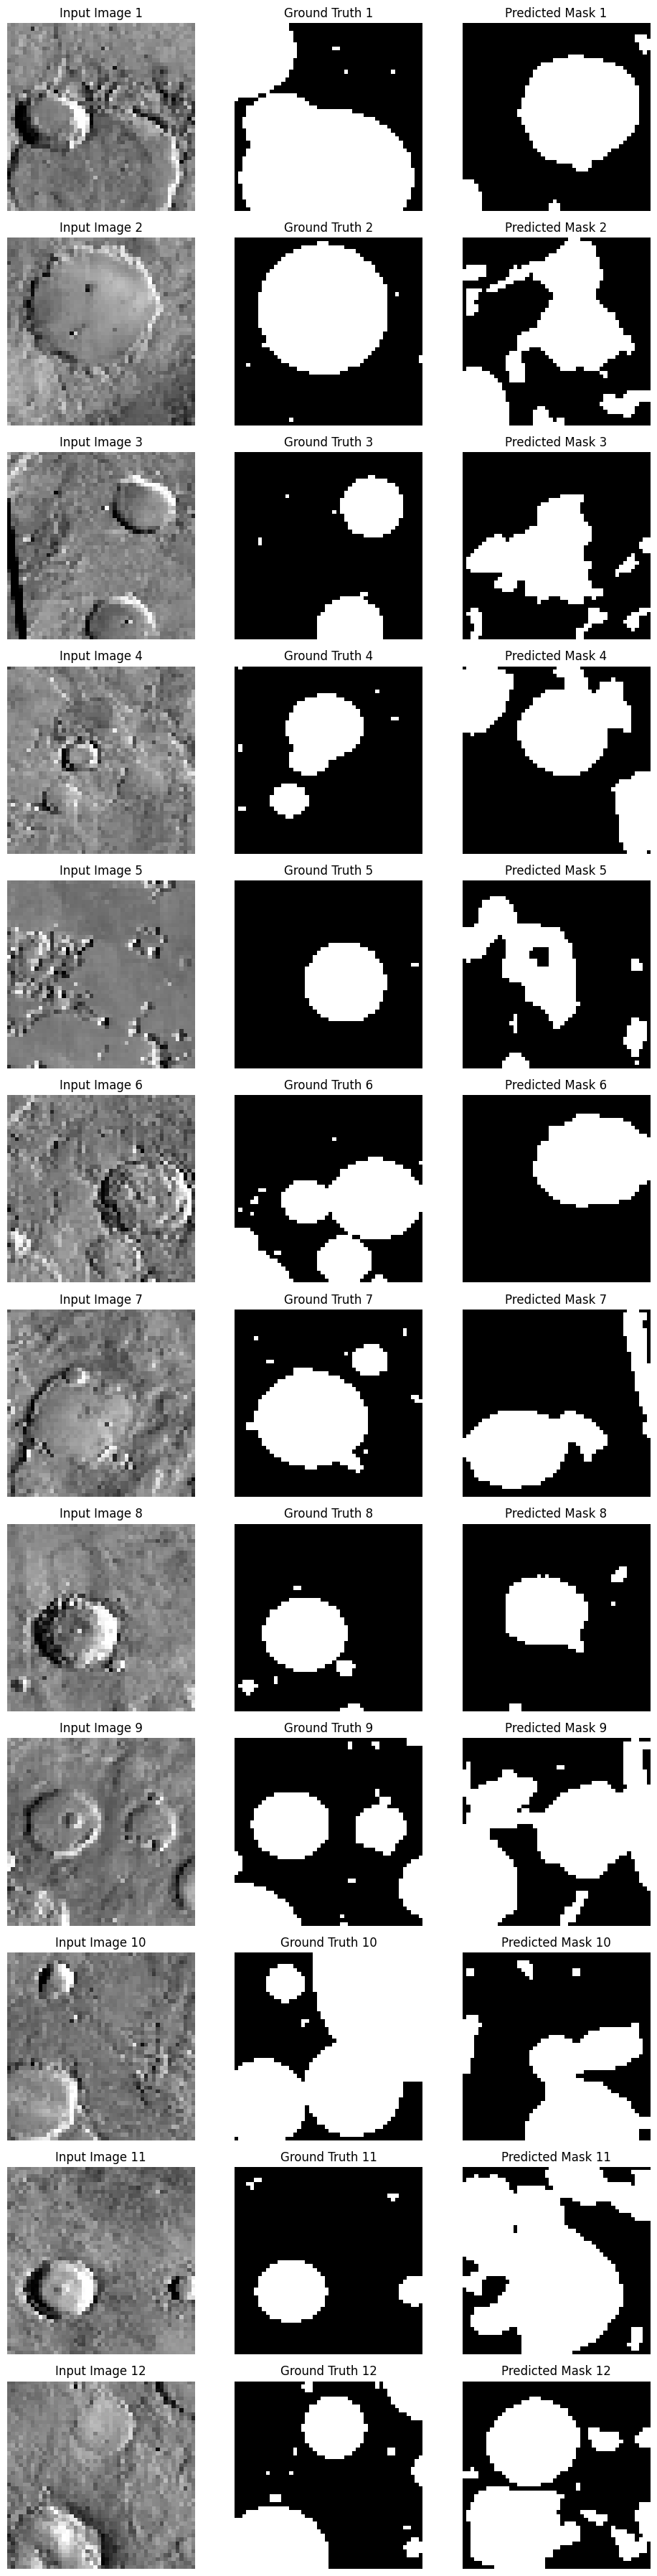

In [ ]:
# Function to display the first 12 predicted masks alongside the ground truth masks
def display_predictions(X_val, Y_val, Y_pred, num_samples=12):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Input image (grayscale)
        axes[i, 0].imshow(X_val[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Input Image {i+1}")
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(Y_val[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Ground Truth {i+1}")
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(Y_pred[i].squeeze(), cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {i+1}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 12 samples with input, ground truth, and predicted mask
display_predictions(X_val, Y_val, Y_pred_binary, num_samples=12)

## Managing imbalance problem with data agumentation


Idea to handle the imbalance problem: we have more black pixels than white ones, find images form the ground through with at least 50% of white pixels and use data agumentation on them to increase the training dataset.

(547, 48, 48, 1, 1)
54


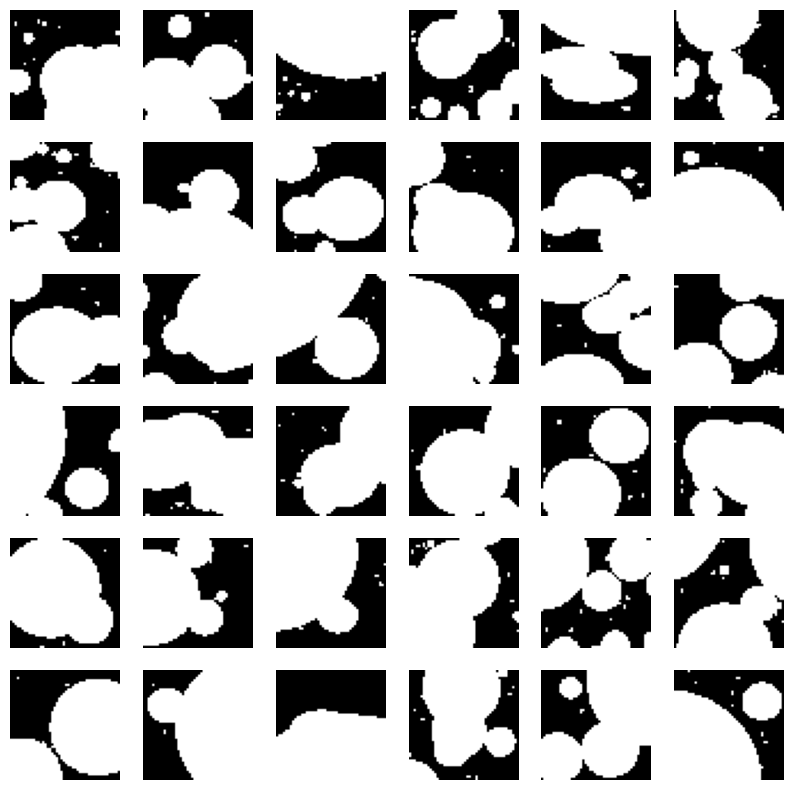

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

def find_high_white_ratio_masks(masks, threshold=0.5):
    high_ratio_indices = []
    for i, mask in enumerate(masks):
        white_pixel_ratio = np.mean(mask)  # Since mask is binary, mean is the ratio of white pixels
        if white_pixel_ratio > threshold:
            high_ratio_indices.append(i)
    return high_ratio_indices

def plot_masks(masks, indices):
    plt.figure(figsize=(10, 10))
    num_images = min(len(indices), 36)
    for i in range(num_images):
        idx = indices[i]
        plt.subplot(6, 6, i + 1)
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Identify masks with high white pixel ratio
high_white_ratio_indices = find_high_white_ratio_masks(Y, threshold=0.5)
print(Y.shape)
print(len(high_white_ratio_indices))

# Visualize the selected masks for confirmation
plot_masks(Y, high_white_ratio_indices)

Only 54/547 have more white pixels than black ones.

In [6]:
# Apply data augmentation on the images with high white pixel ratio
def augment_images(images, masks):
    augmented_images = []
    augmented_masks = []

    for img, mask in zip(images, masks):

        # 90-degree rotation
        augmented_images.append(np.rot90(img, k=1))
        augmented_masks.append(np.rot90(mask, k=1))

        # 180-degree rotation
        augmented_images.append(np.rot90(img, k=2))
        augmented_masks.append(np.rot90(mask, k=2))

        # # 270-degree rotation
        # augmented_images.append(np.rot90(img, k=3))
        # augmented_masks.append(np.rot90(mask, k=3))

        # Horizontal flip
        augmented_images.append(np.fliplr(img))
        augmented_masks.append(np.fliplr(mask))

        # Vertical flip
        augmented_images.append(np.flipud(img))
        augmented_masks.append(np.flipud(mask))

    return np.array(augmented_images), np.array(augmented_masks)

# Select images and masks with high white pixel ratio for augmentation
images_to_augment = X[high_white_ratio_indices]
masks_to_augment = Y[high_white_ratio_indices]

# Augment images and masks
augmented_images, augmented_masks = augment_images(images_to_augment, masks_to_augment)

# Append augmented data to the training set
X_aug = np.concatenate([X, augmented_images], axis=0)
Y_aug = np.concatenate([Y, augmented_masks], axis=0)

print(f"Initial training set size: X_train: {X.shape[0]}, Y_train: {Y.shape[0]}")
print(f"New training set size: X_train: {X_aug.shape[0]}, Y_train: {Y_aug.shape[0]}")
print(f"Number of additional images: {X_aug.shape[0] - X.shape[0]}")

Initial training set size: X_train: 547, Y_train: 547
New training set size: X_train: 763, Y_train: 763
Number of additional images: 216


In [23]:
# Split data into training and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_aug, Y_aug, test_size=0.2, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

# Build the model
input_shape = (48, 48, 1)  # 48x48 images with 1 channel
model_aug = build_unet_model(input_shape)

# Flatten Y_train to a 1D array for class weight computation
Y_train_flat = Y_train.flatten()

# Compute class weights based on the flattened array
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_flat), y=Y_train_flat)

# Create a dictionary to map each class to its corresponding weight
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',  # Can also use 'val_accuracy'
                               patience=7,         # Number of epochs with no improvement after which training stops
                               mode='min',          # 'min' because we want to minimize the validation loss
                               restore_best_weights=True)  # Restore model weights from the epoch with the best loss

# Compile the model with the custom weighted loss
model_aug.compile(optimizer='adam',
              loss=lambda y_true, y_pred: weighted_binary_crossentropy(y_true, y_pred, class_weights_dict),
              metrics=['accuracy'])

# Train the model
history = model_aug.fit(X_train,
                    Y_train,
                    epochs=50,
                    batch_size=16,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping])

# Predict on validation set
Y_pred = model_aug.predict(X_test)

# Convert predictions to binary (threshold 0.5)
Y_pred_binary = (Y_pred > 0.5).astype(np.uint8)

# Flatten predictions and ground truth for comparison
Y_test_flat = Y_test.flatten()
Y_pred_flat = Y_pred_binary.flatten()

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(Y_test_flat, Y_pred_flat)
print(f"Balanced Accuracy: {balanced_acc:.4f}")

Epoch 1/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.5024 - loss: 0.6895 - val_accuracy: 0.6410 - val_loss: 0.6617
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6024 - loss: 0.6724 - val_accuracy: 0.6773 - val_loss: 0.6531
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6313 - loss: 0.6518 - val_accuracy: 0.6784 - val_loss: 0.6276
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6692 - loss: 0.6289 - val_accuracy: 0.6814 - val_loss: 0.6168
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6757 - loss: 0.6248 - val_accuracy: 0.7059 - val_loss: 0.6061
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6912 - loss: 0.6084 - val_accuracy: 0.7145 - val_loss: 0.5995
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7027 - loss: 0.5883 - val_accuracy: 0.6374 - val_loss: 0.6090
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7020 - loss: 0.5795 - val_accuracy: 0.6843 -

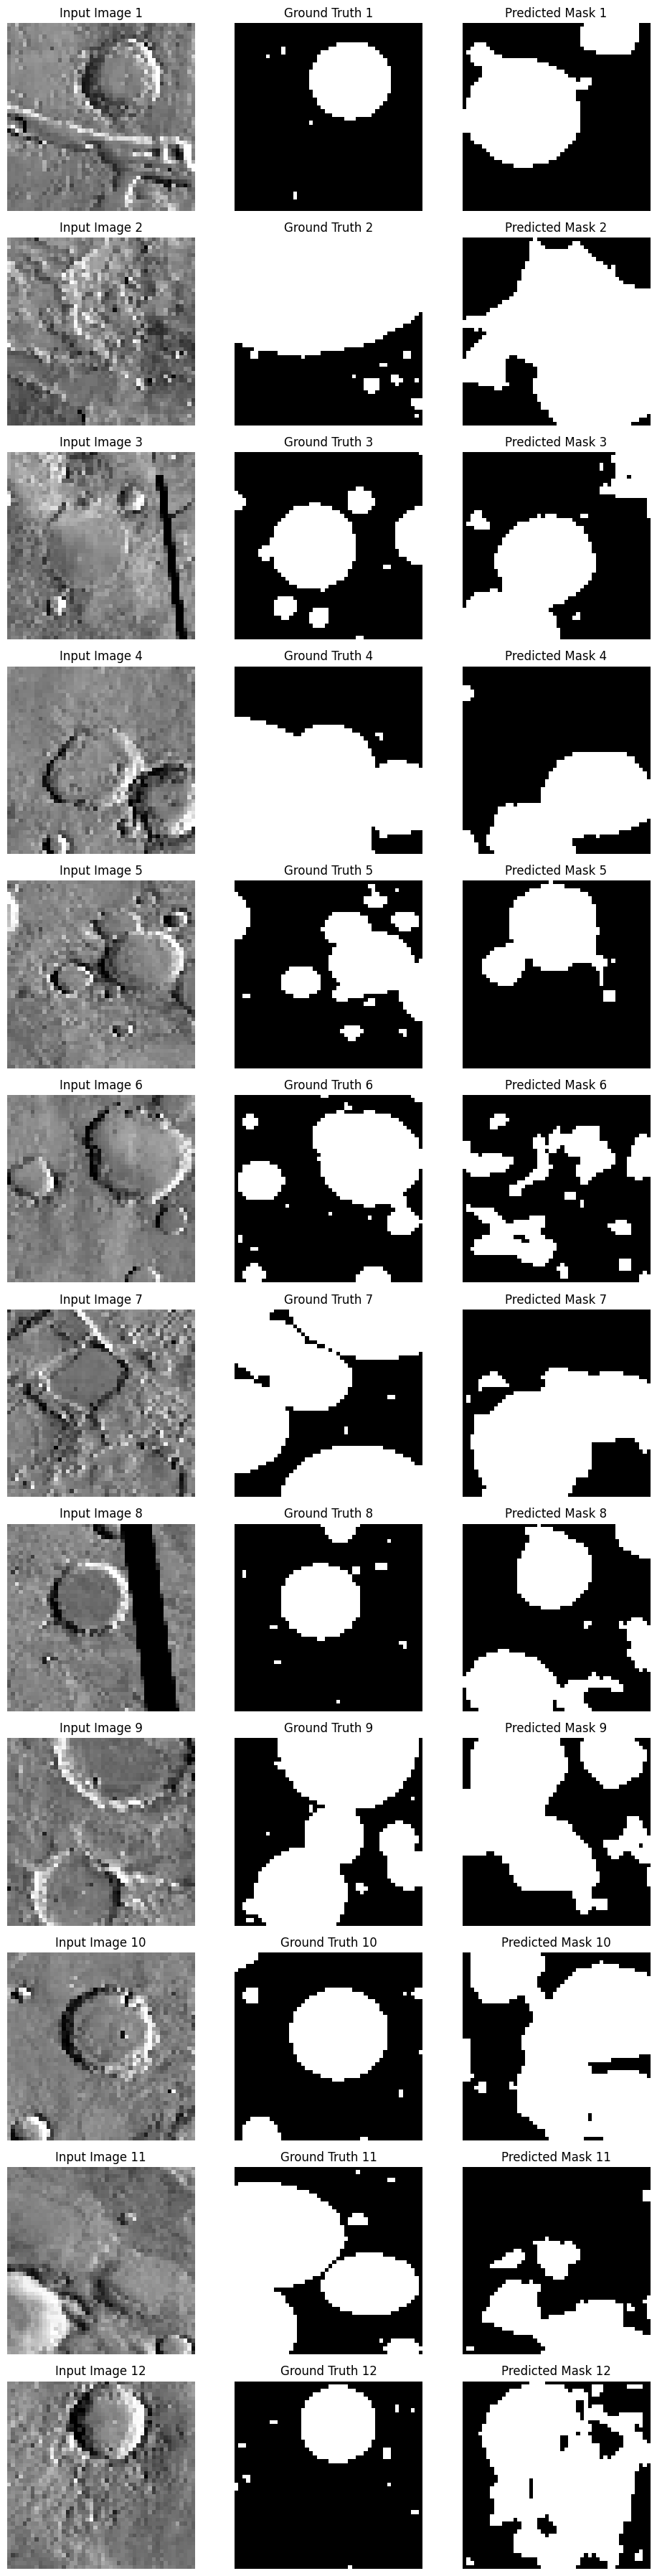

In [24]:
# Function to display the first 12 predicted masks alongside the ground truth masks
def display_predictions(X_val, Y_val, Y_pred, num_samples=12):
    fig, axes = plt.subplots(num_samples, 3, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Input image (grayscale)
        axes[i, 0].imshow(X_val[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Input Image {i+1}")
        axes[i, 0].axis('off')

        # Ground truth mask
        axes[i, 1].imshow(Y_val[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Ground Truth {i+1}")
        axes[i, 1].axis('off')

        # Predicted mask
        axes[i, 2].imshow(Y_pred[i].squeeze(), cmap='gray')
        axes[i, 2].set_title(f"Predicted Mask {i+1}")
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 12 samples with input, ground truth, and predicted mask
display_predictions(X_val, Y_val, Y_pred_binary, num_samples=12)

# Deliver output

In [25]:
Xtest_b_norm = np.array(Xtest_b, dtype=np.float32) / 255.0  # Normalize image pixels to [0, 1]
Xtest_b_norm = Xtest_b_norm.reshape(-1, 48, 48, 1)
Xtest_b_norm = np.expand_dims(Xtest_b_norm, axis=-1)
print(Xtest_b.shape)
print(Xtest_b_norm.shape)
Y_test = model_aug.predict(Xtest_b_norm)
Y_test_binary = (Y_test > 0.5).astype(np.uint8)
print(Y_test_binary.shape)

(196, 2304)
(196, 48, 48, 1, 1)
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step
(196, 48, 48, 1)


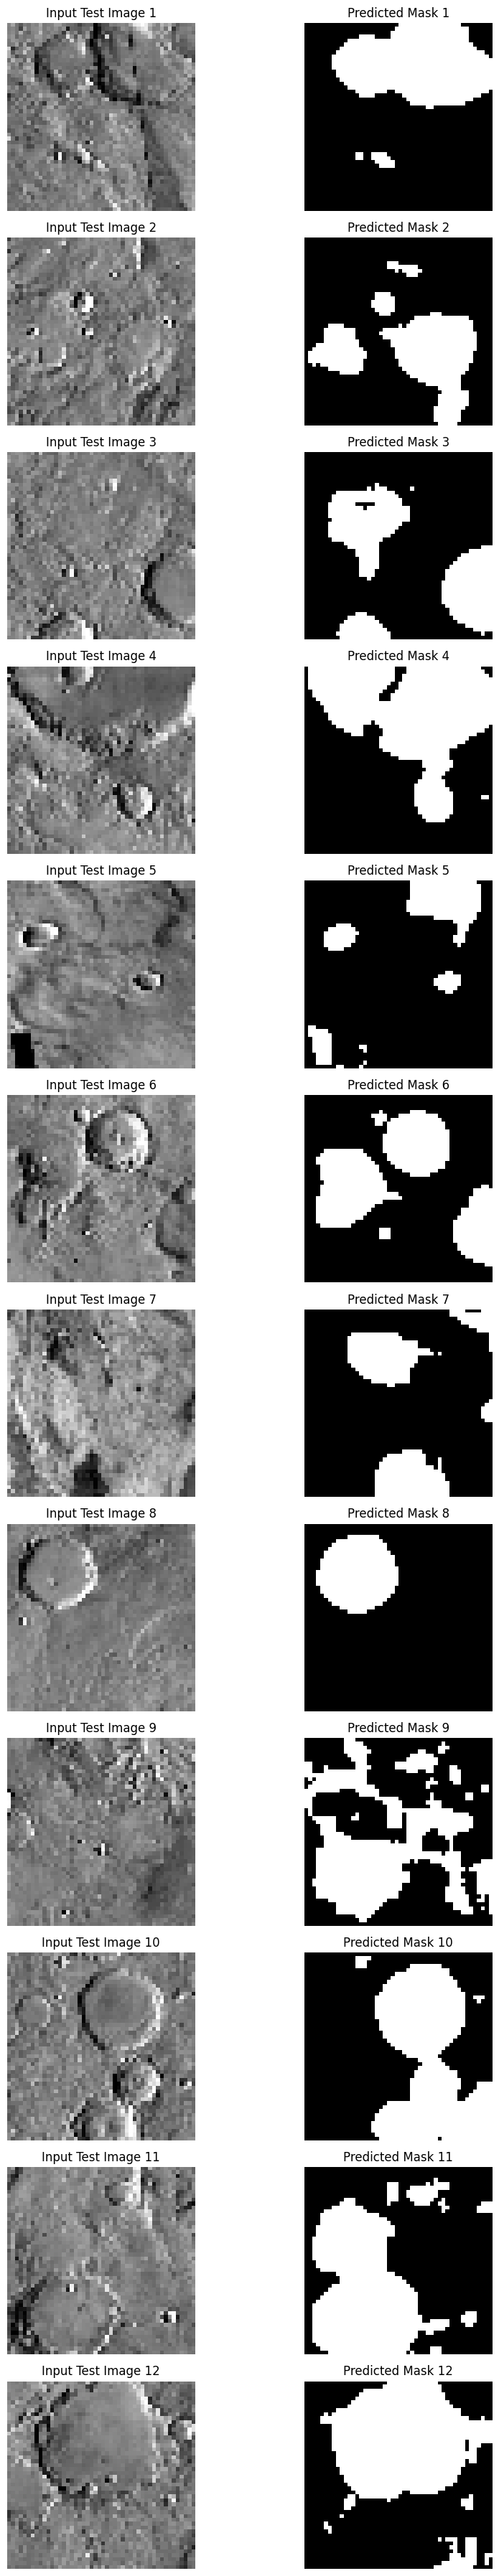

In [31]:
def display_predictions(X_val, Y_pred, num_samples=12):
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 3))

    for i in range(num_samples):
        # Input image (grayscale)
        axes[i, 0].imshow(X_val[i].squeeze(), cmap='gray')
        axes[i, 0].set_title(f"Input Test Image {i+1}")
        axes[i, 0].axis('off')

        # Predicted mask
        axes[i, 1].imshow(Y_pred[i].squeeze(), cmap='gray')
        axes[i, 1].set_title(f"Predicted Mask {i+1}")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Display the first 12 samples with input, ground truth, and predicted mask
display_predictions(Xtest_b_norm, Y_test_binary, num_samples=12)

In [32]:
np.save('Y_test_b.npy', Y_test_binary)